# Building a scan programatically

In this notebook we'll build up a scan definition from first principles, against a local model trained within the
notebook.  We will then run that scan and save its results.  Finally we will extract the scan defintion as YAML, which could be used to run the same scan (potentially on revised models or datasets) via the Certifai stand-alone scanner.

In [1]:
import pandas as pd
import matplotlib as plt
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np
import random
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from copy import copy

from certifai.scanner.builder import (CertifaiScanBuilder, CertifaiPredictorWrapper, CertifaiModel, CertifaiModelMetric,
                                      CertifaiDataset, CertifaiGroupingFeature, CertifaiDatasetSource,
                                      CertifaiPredictionTask, CertifaiTaskOutcomes, CertifaiOutcomeValue)
from certifai.scanner.report_utils import scores, construct_scores_dataframe

In [2]:
# special import - 
# for multiprocessing to work in a Notebook,  pickled classes must be in a separate package or notebook
# hence, the encoder class has to be somewhere other than the current notebook
# from ipynb.fs.defs.cat_encoder import CatEncoder # <- doesn't work on Azure Notebooks
# %run cat_encoder.py # <- doesn't work because code doesn't remain external

# Azure Notebooks workaround - 
import os
import sys
sys.path.append("../utils")
from cat_encoder import CatEncoder

In [3]:
# Example will use a simple logistic classifier on the German Credit dataset
base_path = '..'
all_data_file = f"{base_path}/datasets/german_credit_eval.csv"

df = pd.read_csv(all_data_file)

cat_columns = [
    'checkingstatus',
    'history',
    'purpose',
    'savings',
    'employ',
    'status',
    'others',
    'property',
    'age',
    'otherplans',
    'housing',
    'job',
    'telephone',
    'foreign'
    ]

label_column = 'outcome'

# Separate outcome
y = df[label_column]
X = df.drop(label_column, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Note - to support python multi-processing in the context of a notebook the encoder MUST
# be in a separate file, which is why `CatEncoder` is defined outside of this notebook
encoder = CatEncoder(cat_columns, X)

def build_model(data, name, model_family, test=None):
    if test is None:
        test = data
        
    if model_family == 'SVM':
        parameters = {'kernel':('linear', 'rbf', 'poly'), 'C':[0.1, .5, 1, 2, 4, 10], 'gamma':['auto']}
        m = svm.SVC()
    elif model_family == 'logistic':
        parameters = {'C': (0.5, 1.0, 2.0), 'solver': ['lbfgs'], 'max_iter': [1000]}
        m = LogisticRegression()
    model = GridSearchCV(m, parameters, cv=3)
    model.fit(data[0], data[1])

    # Assess on the test data
    accuracy = model.score(test[0], test[1].values)
    print(f"Model '{name}' accuracy is {accuracy}")
    return model

svm_model = build_model((encoder(X_train.values), y_train),
                        'Support Vector Machine',
                        'SVM',
                        test=(encoder(X_test.values), y_test))

logistic_model = build_model((encoder(X_train.values), y_train),
                        'Logistic classifier',
                        'logistic',
                        test=(encoder(X_test.values), y_test))

Model 'Support Vector Machine' accuracy is 0.77
Model 'Logistic classifier' accuracy is 0.77


In [4]:
# Wrap the model up for use by Certifai as a local model
svm_model_proxy = CertifaiPredictorWrapper(svm_model, encoder=encoder)
logistic_model_proxy = CertifaiPredictorWrapper(logistic_model, encoder=encoder)

In [5]:
# Create the scan object from scratch using the ScanBuilder class

# First define the possible prediction outcomes
task = CertifaiPredictionTask(CertifaiTaskOutcomes.classification(
    [
        CertifaiOutcomeValue(1, name='Loan granted', favorable=True),
        CertifaiOutcomeValue(2, name='Loan denied')
    ]),
    prediction_description='Determine whether a loan should be granted')

scan = CertifaiScanBuilder.create('test_user_case',
                                  prediction_task=task)

# Add our local models
first_model = CertifaiModel('SVM',
                            local_predictor=svm_model_proxy)
scan.add_model(first_model)
second_model = CertifaiModel('logistic',
                            local_predictor=logistic_model_proxy)
scan.add_model(second_model)

# Add the eval dataset
eval_dataset = CertifaiDataset('evaluation',
                               CertifaiDatasetSource.csv(all_data_file))
scan.add_dataset(eval_dataset)

# Setup an evaluation for fairness on the above dataset using the model
# We'll look at disparity between groups defined by marital status and age
scan.add_fairness_grouping_feature(CertifaiGroupingFeature('age'))
scan.add_fairness_grouping_feature(CertifaiGroupingFeature('status'))
scan.add_evaluation_type('fairness')
scan.evaluation_dataset_id = 'evaluation'

# Because the dataset contains a ground truth outcome column which the model does not
# expect to receive as input we need to state that in the dataset schema (since it cannot
# be inferred from the CSV)
scan.dataset_schema.outcome_feature_name = 'outcome'

# Run the scan.
# By default this will write the results into individual report files (one per model and evaluation
# type) in the 'reports' directory relative to the Jupyter root.  This may be disabled by specifying
# `write_reports=False` as below
# The result is a dictionary of dictionaries of reports.  The top level dict key is the evaluation type
# and the second level key is model id.
# Reports saved as JSON (which `write_reports=True` will do) may be visualized in the console app
result = scan.run(write_reports=False)


Starting scan with model_use_case_id: 'test_user_case' and scan_id: '156ab72c4bfd'
[--------------------] 2020-05-28 12:05:50.484950 - 0 of 2 reports (0.0% complete) - Running fairness evaluation for model: SVM


2020-05-28 12:05:50,806 root   WARNING  Insufficient examples of some fairness classes to guarantee convergence (smallest class size is for 'male : divorced/separated' with 50 samples)
2020-05-28 12:09:13,301 root   WARNING  Examples of protected class (8, 'male : divorced/separated') exhausted before convergence after 50 samples
2020-05-28 12:10:47,221 root   WARNING  Examples of protected class (8, 'male : married/widowed') exhausted before convergence after 92 samples
2020-05-28 12:13:39,091 root   WARNING  Examples of protected class (12, '<= 25 years') exhausted before convergence after 190 samples
2020-05-28 12:16:01,775 root   WARNING  Examples of protected class (8, 'female : divorced/separated/married') exhausted before convergence after 310 samples
2020-05-28 12:16:14,788 root   WARNING  Examples of protected class (12, '> 25 years') exhausted before convergence after 810 samples
2020-05-28 12:16:14,789 root   WARNING  Examples of protected class (8, 'male : single') exhauste

[##########----------] 2020-05-28 12:16:53.726643 - 1 of 2 reports (50.0% complete) - Running fairness evaluation for model: logistic


2020-05-28 12:16:53,802 root   WARNING  Insufficient examples of some fairness classes to guarantee convergence (smallest class size is for 'male : divorced/separated' with 50 samples)
2020-05-28 12:19:30,682 root   WARNING  Examples of protected class (8, 'male : divorced/separated') exhausted before convergence after 50 samples
2020-05-28 12:20:22,936 root   WARNING  Examples of protected class (8, 'male : married/widowed') exhausted before convergence after 92 samples
2020-05-28 12:21:12,526 root   WARNING  Examples of protected class (12, '<= 25 years') exhausted before convergence after 190 samples
2020-05-28 12:22:49,041 root   WARNING  Examples of protected class (8, 'female : divorced/separated/married') exhausted before convergence after 310 samples
2020-05-28 12:23:02,550 root   WARNING  Examples of protected class (12, '> 25 years') exhausted before convergence after 810 samples
2020-05-28 12:23:02,551 root   WARNING  Examples of protected class (8, 'male : single') exhauste

[####################] 2020-05-28 12:23:48.670591 - 2 of 2 reports (100.0% complete) - Completed all evaluations


In [6]:
# The result is a dictionary keyed on analysis, containing reports keyed on model id
# The console app is the recommended way to view these, by saving the results to file
# (see previous cell), but programmatic analysis of the result here is also possible
print(type(result['fairness']['SVM']['fairness']['secondary_scores']))
df = construct_scores_dataframe(scores('fairness', result), include_confidence=False)
display(df)

<class 'list'>


,context,type,overall fairness,Feature (age),Group details (<= 25 years),Group details (> 25 years),Feature (status),Group details (female : divorced/separated/married),Group details (male : divorced/separated),Group details (male : married/widowed),Group details (male : single)
SVM (burden),SVM,burden,68.780614,73.525768,0.062587,0.036228,70.876210,0.059006,0.053773,0.020163,0.033310
logistic (burden),logistic,burden,67.045981,68.397077,0.069139,0.036116,72.435434,0.063271,0.064733,0.027758,0.031458


,context,type,overall fairness,overall fairness lower bound,overall fairness upper bound,Feature (age),Feature (age) lower bound,Feature (age) upper bound,Group details (<= 25 years),Group details (<= 25 years) lower bound,...,Group details (female : divorced/separated/married) upper bound,Group details (male : divorced/separated),Group details (male : divorced/separated) lower bound,Group details (male : divorced/separated) upper bound,Group details (male : married/widowed),Group details (male : married/widowed) lower bound,Group details (male : married/widowed) upper bound,Group details (male : single),Group details (male : single) lower bound,Group details (male : single) upper bound
SVM (burden),SVM,burden,68.780614,60.561401,76.336978,73.525768,64.118056,84.718001,0.062587,0.050866,...,0.069675,0.053773,0.030159,0.080744,0.020163,0.011677,0.029790,0.033310,0.027853,0.039773
logistic (burden),logistic,burden,67.045981,58.630207,74.399401,68.397077,59.534515,78.662533,0.069139,0.057396,...,0.085122,0.064733,0.041807,0.096283,0.027758,0.017036,0.042137,0.031458,0.026277,0.042649


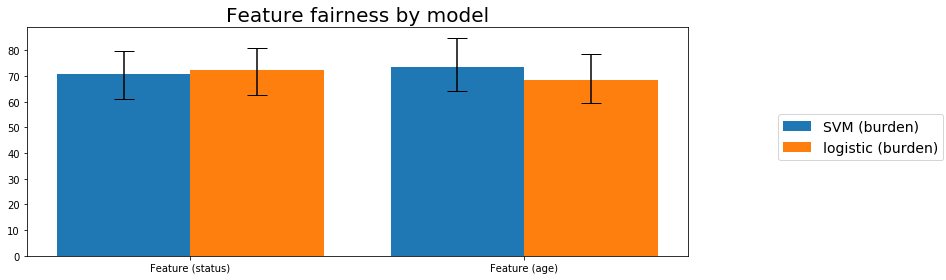

In [7]:
# Many scores also come with 95% confidence bounds, which we omitted above for the sake of brevity, but
# we can include those also.  In the example here we include the confidence bounds but only display the scores
# to a reduced level of detail to keep a smallish table for display purposes
df = construct_scores_dataframe(scores('fairness', result, max_depth=1))

display(df)

print("\n")

# Let's chart the fairness measure by feature for each model together with its confidence bounds for
# easier visual comparison:
%matplotlib inline
import matplotlib.pyplot as plt

features = ['Feature (status)', 'Feature (age)']
feature_scores = df[features]
feature_lower_bounds = df[[f + ' lower bound' for f in features]]
feature_upper_bounds = df[[f + ' upper bound' for f in features]]

fig, ax = plt.subplots(figsize=[12,4])
ax.set_title('Feature fairness by model', fontsize=20)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:pink']
width = 0.4

ax.set_xticks(np.arange(len(features))+width)
ax.set_xticklabels(features)

for idx in range(len(df)):
    central_values = list(feature_scores.iloc[idx])
    lower_bounds = list(feature_lower_bounds.iloc[idx])
    upper_bounds = list(feature_upper_bounds.iloc[idx])
    lower_errors = [central_values[i] - lower_bounds[i] for i in range(len(central_values))]
    upper_errors = [upper_bounds[i] - central_values[i] for i in range(len(central_values))]

    ax.bar([width/2+idx*width+f_idx for f_idx in range(len(features))],
            central_values,
            width,
            yerr=[lower_errors, upper_errors],
            color=colors[idx],
            label=df.index[idx],
            capsize=10)

fig.legend(fontsize=14, bbox_to_anchor=(1.1,.6))
fig.tight_layout()
fig.subplots_adjust(right=0.8) 
plt.show()

In [8]:
# We can also persist the template we built and reuse it later as illustrated here
import tempfile
import yaml

temp_file = tempfile.mktemp()
with open(temp_file, "w") as f:
    scan.save(f)
    print(f"Saved template to: {temp_file}")

Saved template to: /var/folders/cq/_lb8g8w5133gjjkgc729xtlnkx_dd1/T/tmpg07gdjpk


In [9]:
reloaded = CertifaiScanBuilder.from_file(temp_file)

# The persisted scan won't contain the model itself, so we'll need to reconnect that
for model in reloaded.models:
    if model.id == 'logistic':
        model.local_predictor=logistic_model_proxy
    elif model.id == 'SVM':
        model.local_predictor=svm_model_proxy

In [10]:
result = reloaded.run(write_reports=False)

[--------------------] 2020-05-28 12:23:49.590896 - 0 of 2 reports (0.0% complete) - Starting scan with model_use_case_id: 'test_user_case' and scan_id: '613af6c687cf'
[--------------------] 2020-05-28 12:23:49.591677 - 0 of 2 reports (0.0% complete) - Running fairness evaluation for model: SVM


2020-05-28 12:23:49,673 root   WARNING  Insufficient examples of some fairness classes to guarantee convergence (smallest class size is for 'male : divorced/separated' with 50 samples)
2020-05-28 12:26:37,553 root   WARNING  Examples of protected class (8, 'male : divorced/separated') exhausted before convergence after 50 samples
2020-05-28 12:27:51,033 root   WARNING  Examples of protected class (8, 'male : married/widowed') exhausted before convergence after 92 samples
2020-05-28 12:30:14,272 root   WARNING  Examples of protected class (12, '<= 25 years') exhausted before convergence after 190 samples
2020-05-28 12:32:53,152 root   WARNING  Examples of protected class (8, 'female : divorced/separated/married') exhausted before convergence after 310 samples
2020-05-28 12:33:09,483 root   WARNING  Examples of protected class (12, '> 25 years') exhausted before convergence after 810 samples
2020-05-28 12:33:09,485 root   WARNING  Examples of protected class (8, 'male : single') exhauste

[##########----------] 2020-05-28 12:33:59.948518 - 1 of 2 reports (50.0% complete) - Running fairness evaluation for model: logistic


2020-05-28 12:34:00,029 root   WARNING  Insufficient examples of some fairness classes to guarantee convergence (smallest class size is for 'male : divorced/separated' with 50 samples)
2020-05-28 12:36:55,718 root   WARNING  Examples of protected class (8, 'male : divorced/separated') exhausted before convergence after 50 samples
2020-05-28 12:37:52,479 root   WARNING  Examples of protected class (8, 'male : married/widowed') exhausted before convergence after 92 samples
2020-05-28 12:38:56,454 root   WARNING  Examples of protected class (12, '<= 25 years') exhausted before convergence after 190 samples
2020-05-28 12:41:03,649 root   WARNING  Examples of protected class (8, 'female : divorced/separated/married') exhausted before convergence after 310 samples
2020-05-28 12:41:19,330 root   WARNING  Examples of protected class (12, '> 25 years') exhausted before convergence after 810 samples
2020-05-28 12:41:19,331 root   WARNING  Examples of protected class (8, 'male : single') exhauste

[####################] 2020-05-28 12:42:11.711092 - 2 of 2 reports (100.0% complete) - Completed all evaluations


In [11]:
construct_scores_dataframe(scores('fairness', result), include_confidence=False)

,context,type,overall fairness,Feature (age),Group details (<= 25 years),Group details (> 25 years),Feature (status),Group details (female : divorced/separated/married),Group details (male : divorced/separated),Group details (male : married/widowed),Group details (male : single)
SVM (burden),SVM,burden,68.780614,73.525768,0.062587,0.036228,70.876210,0.059006,0.053773,0.020163,0.033310
logistic (burden),logistic,burden,67.045981,68.397077,0.069139,0.036116,72.435434,0.063271,0.064733,0.027758,0.031458


In [12]:
# We can also process dataframes we have locally already loaded in Pandas rather than
# requiring them to initially be saved off as CSV/JSON files
df2 = pd.read_csv(all_data_file)

# Add this already loaded data as a new dataset and switch to evaluate it
loaded_dataset = CertifaiDataset('loaded', CertifaiDatasetSource.dataframe(df2))
reloaded.add_dataset(loaded_dataset)
reloaded.evaluation_dataset_id = 'loaded'
reloaded.output_path = '../local_reports'

result = reloaded.run()

[--------------------] 2020-05-28 12:42:11.916615 - 0 of 2 reports (0.0% complete) - Starting scan with model_use_case_id: 'test_user_case' and scan_id: 'e4f38b67b16f'
[--------------------] 2020-05-28 12:42:11.917969 - 0 of 2 reports (0.0% complete) - Running fairness evaluation for model: SVM


2020-05-28 12:42:12,047 root   WARNING  Insufficient examples of some fairness classes to guarantee convergence (smallest class size is for 'male : divorced/separated' with 50 samples)
2020-05-28 12:45:09,673 root   WARNING  Examples of protected class (8, 'male : divorced/separated') exhausted before convergence after 50 samples
2020-05-28 12:46:32,534 root   WARNING  Examples of protected class (8, 'male : married/widowed') exhausted before convergence after 92 samples
2020-05-28 12:49:30,101 root   WARNING  Examples of protected class (12, '<= 25 years') exhausted before convergence after 190 samples
2020-05-28 12:52:19,995 root   WARNING  Examples of protected class (8, 'female : divorced/separated/married') exhausted before convergence after 310 samples
2020-05-28 12:52:34,970 root   WARNING  Examples of protected class (12, '> 25 years') exhausted before convergence after 810 samples
2020-05-28 12:52:34,971 root   WARNING  Examples of protected class (8, 'male : single') exhauste

[##########----------] 2020-05-28 12:53:25.186053 - 1 of 2 reports (50.0% complete) - Running fairness evaluation for model: logistic


2020-05-28 12:53:25,279 root   WARNING  Insufficient examples of some fairness classes to guarantee convergence (smallest class size is for 'male : divorced/separated' with 50 samples)
2020-05-28 12:56:27,039 root   WARNING  Examples of protected class (8, 'male : divorced/separated') exhausted before convergence after 50 samples
2020-05-28 12:57:31,067 root   WARNING  Examples of protected class (8, 'male : married/widowed') exhausted before convergence after 92 samples
2020-05-28 12:58:35,001 root   WARNING  Examples of protected class (12, '<= 25 years') exhausted before convergence after 190 samples
2020-05-28 13:00:32,083 root   WARNING  Examples of protected class (8, 'female : divorced/separated/married') exhausted before convergence after 310 samples
2020-05-28 13:00:47,651 root   WARNING  Examples of protected class (12, '> 25 years') exhausted before convergence after 810 samples
2020-05-28 13:00:47,652 root   WARNING  Examples of protected class (8, 'male : single') exhauste

[####################] 2020-05-28 13:01:38.326459 - 2 of 2 reports (100.0% complete) - Completed all evaluations


In [13]:
construct_scores_dataframe(scores('fairness', result), include_confidence=False)

,context,type,overall fairness,Feature (age),Group details (<= 25 years),Group details (> 25 years),Feature (status),Group details (female : divorced/separated/married),Group details (male : divorced/separated),Group details (male : married/widowed),Group details (male : single)
SVM (burden),SVM,burden,68.780614,73.525768,0.062587,0.036228,70.876210,0.059006,0.053773,0.020163,0.033310
logistic (burden),logistic,burden,67.045981,68.397077,0.069139,0.036116,72.435434,0.063271,0.064733,0.027758,0.031458


In [14]:
# Having developed a scan definition we'll eventually want to be able to export it for use in
# scans of a deployed model.  The main differences then will be:
#  * The model won't be local to the scanner, but will be accessed via the network
#  * The dataset won't be in a local DataFrame but will always be read from (possibly network attached) storage
# This means that the scan template used by the scanner will need dataset sourcing details filling in, and model
# endpoint address specifying.  This can either be done by a post-hoc hand edit of the produced YAML (the file we
# saved off earlier to illustrate persisting the template), or we can add those details programatically prior to
# exporting as illustrated below
exportable_scan = CertifaiScanBuilder.from_file(temp_file)  # reload the scan we've been using in the notebook
exportable_scan.models[0].predict_endpoint = 'http://mymodel/predict'
exportable_scan.datasets[0].source = CertifaiDatasetSource.csv('somefile.csv')

# Export the updated scan as YAML for use by the scanner (we won't actually save it here - just print it)
scan_yaml = exportable_scan.extract_yaml() # could use the method `save` to write direct to a file
print(scan_yaml)

dataset_schema:
  outcome_column: outcome
datasets:
- dataset_id: evaluation
  delimiter: ','
  file_type: csv
  has_header: true
  quote_character: '"'
  url: somefile.csv
evaluation:
  evaluation_dataset_id: evaluation
  evaluation_types:
  - fairness
  fairness_grouping_features:
  - name: age
  - name: status
  name: test_user_case
  prediction_description: Determine whether a loan should be granted
  prediction_favorability: explicit
  prediction_values:
  - favorable: true
    name: Loan granted
    value: 1
  - favorable: false
    name: Loan denied
    value: 2
model_use_case:
  model_use_case_id: test_user_case
  name: test_user_case
  task_type: binary-classification
models:
- model_id: SVM
  name: SVM
  predict_endpoint: http://mymodel/predict
  prediction_value_order:
  - 1
  - 2
- model_id: logistic
  name: logistic
  prediction_value_order:
  - 1
  - 2

